# SRCNN

## Preview

*   **Core Idea:** SRCNN learns a direct, end-to-end mapping from a low-resolution image (after bicubic interpolation) to a high-resolution image.
*   **Preprocessing:** The only preprocessing step is to upscale the low-resolution image to the target size using bicubic interpolation. The network's job is to correct the errors introduced by this simple upscaling.
*   **Architecture (The "9-5-5" model):** The paper experiments with several configurations. I will implement their best-performing three-layer model, which is denoted as 9-5-5, referring to the kernel sizes.
    1.  **Layer 1: Patch Extraction and Representation.** This is a convolutional layer that extracts overlapping patches from the input image and represents them as a set of feature maps.
        *   **Kernel Size:** `f1 = 9x9`
        *   **Number of Filters:** `n1 = 64`
        *   **Activation:** ReLU
    2.  **Layer 2: Non-linear Mapping.** This layer maps the 64-dimensional feature vectors to a 32-dimensional space. This can be seen as a non-linear mapping of the low-resolution patch representations to high-resolution ones.
        *   **Kernel Size:** `f2 = 5x5` (The paper also tests 1x1, but 5x5 is more powerful).
        *   **Number of Filters:** `n2 = 32`
        *   **Activation:** ReLU
    3.  **Layer 3: Reconstruction.** This final layer aggregates the high-resolution patch representations to produce the final, reconstructed image. It's a linear convolutional layer, without a subsequent activation function, as we want to output the raw pixel values.
        *   **Kernel Size:** `f3 = 5x5`
        *   **Number of Filters:** `c = 3` (for RGB channels, the paper focused on 1 for luminance).
*   **Loss Function:** The model is trained by minimizing the Mean Squared Error (MSE) between the network's output and the ground-truth high-resolution image. This choice directly optimizes for a high Peak Signal-to-Noise Ratio (PSNR), which was the primary evaluation metric.


## Experiment Implementation

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math

# Step 2: Dataset Preparation
class SuperResolutionDataset(Dataset):
    """
    Custom PyTorch Dataset for Super-Resolution.
    It takes a dataset of high-resolution images and generates
    low-resolution/high-resolution pairs on the fly.
    """
    def __init__(self, hq_dataset, scale_factor=3, target_size=(256, 256)):
        self.hq_dataset = hq_dataset
        self.scale_factor = scale_factor
        self.target_size = target_size
        self.dataset_list = list(hq_dataset.as_numpy_iterator())

        # Transformation for the high-resolution (target) image
        self.hq_transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        # 1. Get the high-resolution image
        hq_image_data = self.dataset_list[index]['image']
        hq_image = Image.fromarray(hq_image_data)

        # Resize to fixed target size first
        hq_image = hq_image.resize(self.target_size, Image.BICUBIC)

        # 2. Create the low-resolution image by downscaling
        hq_width, hq_height = hq_image.size
        lq_width, lq_height = hq_width // self.scale_factor, hq_height // self.scale_factor
        lq_image = hq_image.resize((lq_width, lq_height), Image.BICUBIC)

        # 3. Create the input image by upscaling the low-res image
        # This is the bicubic interpolated image that serves as the network's input
        input_image = lq_image.resize((hq_width, hq_height), Image.BICUBIC)

        # 4. Convert images to tensors
        # The network learns to map the 'input_image' to the 'hq_image'
        input_tensor = self.hq_transform(input_image)
        target_tensor = self.hq_transform(hq_image)

        return input_tensor, target_tensor

    def __len__(self):
        return len(self.dataset_list)

# Step 3: SRCNN Model Implementation
class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(SRCNN, self).__init__()
        # Note: The paper uses 1 channel (luminance), but we adapt for 3 (RGB).

        # Layer 1: Patch extraction and representation.
        # Kernel size 9x9, 64 filters. Padding is (9-1)/2 = 4 to keep size constant.
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)

        # Layer 2: Non-linear mapping.
        # Kernel size 5x5, 32 filters. Padding is (5-1)/2 = 2.
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)

        # Layer 3: Reconstruction.
        # Kernel size 5x5, back to original channels. Padding is (5-1)/2 = 2.
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=2)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # As per the paper's architecture diagram (Fig. 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x) # No ReLU on the final layer
        return x

# Utility function to calculate PSNR
def psnr(mse, max_val=1.0):
    if mse == 0:
        return 100
    return 10 * math.log10(max_val**2 / mse)

In [11]:
print("Loading tf_flowers dataset...")
# Using TensorFlow Datasets to load the data
(ds_train, ds_val), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=False, # We want the dictionary, not a tuple
)

# Create PyTorch Datasets and DataLoaders
scale_factor = 3
target_image_size = (256, 256) # Define a fixed size for all images
train_dataset = SuperResolutionDataset(ds_train, scale_factor=scale_factor, target_size=target_image_size)
val_dataset = SuperResolutionDataset(ds_val, scale_factor=scale_factor, target_size=target_image_size)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

print("Dataset prepared.")

Loading tf_flowers dataset...
Dataset prepared.


In [12]:
# 2. Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SRCNN().to(device)
criterion = nn.MSELoss()
# The paper uses SGD, but Adam is a more robust default for modern deep learning.
# This is a noted deviation from the original paper for faster convergence.
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda


In [13]:
# 3. Training Loop
num_epochs = 15 # A short run for demonstration
print("Starting training...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.6f}")

    # 4. Validation Loop
    model.eval()
    avg_psnr = 0
    avg_bicubic_psnr = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            # Calculate PSNR for the model's output
            mse = criterion(outputs, targets)
            avg_psnr += psnr(mse.item())

            # Calculate PSNR for the bicubic input to see the improvement
            bicubic_mse = criterion(inputs, targets)
            avg_bicubic_psnr += psnr(bicubic_mse.item())

    avg_psnr /= len(val_loader)
    avg_bicubic_psnr /= len(val_loader)
    print(f"Validation PSNR: {avg_psnr:.4f} dB | Bicubic PSNR: {avg_bicubic_psnr:.4f} dB")
    print("-" * 20)

print("Training finished.")

Starting training...
Epoch [1/15], Loss: 0.017570
Validation PSNR: 24.2751 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [2/15], Loss: 0.004032
Validation PSNR: 25.7043 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [3/15], Loss: 0.003535
Validation PSNR: 26.0485 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [4/15], Loss: 0.003348
Validation PSNR: 26.2718 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [5/15], Loss: 0.003263
Validation PSNR: 26.4008 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [6/15], Loss: 0.003185
Validation PSNR: 26.4915 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [7/15], Loss: 0.003156
Validation PSNR: 26.6648 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [8/15], Loss: 0.003113
Validation PSNR: 26.7324 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [9/15], Loss: 0.003078
Validation PSNR: 26.7745 dB | Bicubic PSNR: 26.3685 dB
--------------------
Epoch [10/15], Loss: 0.003052
Vali

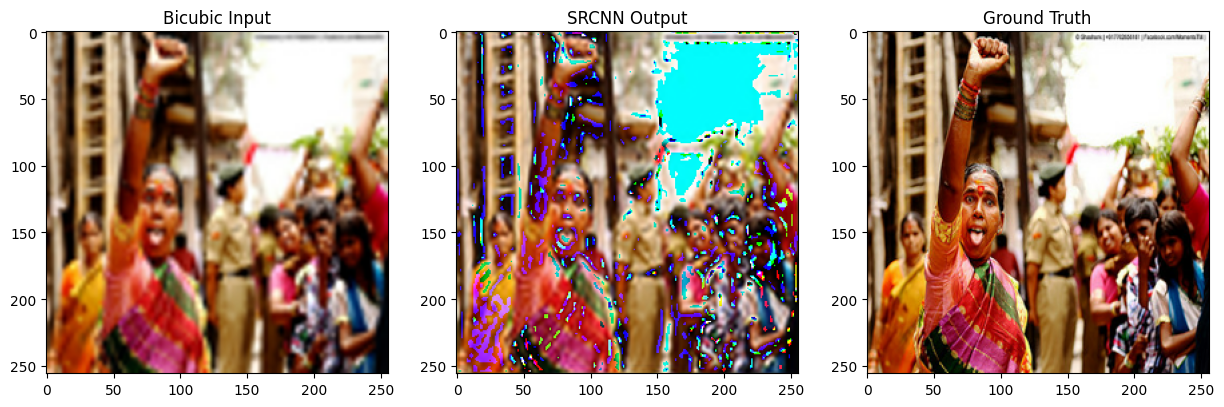

In [14]:
# 5. Visualize a result
model.eval()
input_img, target_img = val_dataset[10] # Get a sample image
input_tensor = input_img.unsqueeze(0).to(device)

with torch.no_grad():
    output_tensor = model(input_tensor)

# Convert tensors to images for display
output_img = transforms.ToPILImage()(output_tensor.cpu().squeeze(0))
input_display_img = transforms.ToPILImage()(input_img)
target_display_img = transforms.ToPILImage()(target_img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Bicubic Input")
plt.imshow(input_display_img)
plt.subplot(1, 3, 2)
plt.title("SRCNN Output")
plt.imshow(output_img)
plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(target_display_img)
plt.show()

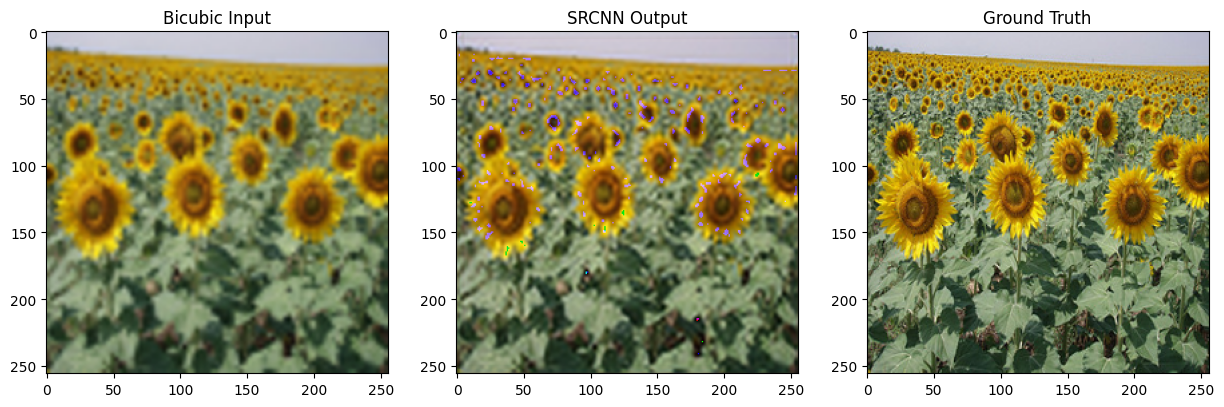

In [15]:
model.eval()
input_img, target_img = val_dataset[9] # Get a sample image
input_tensor = input_img.unsqueeze(0).to(device)

with torch.no_grad():
    output_tensor = model(input_tensor)

# Convert tensors to images for display
output_img = transforms.ToPILImage()(output_tensor.cpu().squeeze(0))
input_display_img = transforms.ToPILImage()(input_img)
target_display_img = transforms.ToPILImage()(target_img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Bicubic Input")
plt.imshow(input_display_img)
plt.subplot(1, 3, 2)
plt.title("SRCNN Output")
plt.imshow(output_img)
plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(target_display_img)
plt.show()

## Critical Analysis

#### **Weakness 1: High Computational Cost due to Pre-upsampling**
*   **The SRCNN Approach:** SRCNN first upscales the low-resolution (LR) image to the target size with bicubic interpolation and then feeds this larger image into the network. This means all convolutional operations happen in the high-resolution space, which is computationally expensive and slow.
*   **SOTA Evolution (FSRCNN, ESPCN):** Later models like Fast Super-Resolution CNN (FSRCNN) and the Efficient Sub-Pixel CNN (ESPCN) perform the bulk of their computations in the low-resolution space. They introduce a learnable upscaling layer at the very end of the network. ESPCN's "pixel shuffle" layer is particularly notable; it learns to rearrange pixels from a set of LR feature maps into a single high-resolution image, which is far more efficient.

#### **Weakness 2: Shallow Architecture & Limited Receptive Field**
*   **The SRCNN Approach:** With only three layers, SRCNN has a limited receptive field. This means the prediction for any given output pixel is based on a relatively small area of the input image, restricting its ability to capture larger contextual details.
*   **SOTA Evolution (VDSR, EDSR, RCAN):** The Very-Deep Super-Resolution (VDSR) network demonstrated that much deeper architectures (e.g., 20 layers) significantly improve performance. This is possible through the introduction of residual learning.

#### **Weakness 3: Inefficient Learning Target**
*   **The SRCNN Approach:** The network learns to map the interpolated LR image to the HR image. Since the interpolated image is already very similar to the target HR image, the network wastes capacity learning identity mappings for low-frequency information that is already present.
*   **SOTA Evolution (VDSR):** The key insight of VDSR was **global residual learning**. Instead of learning the HR image directly, the network learns to predict the *residual*—the difference between the HR image and the interpolated LR image. The final output is created by simply adding this learned residual to the input. This frees the network to focus exclusively on restoring the missing high-frequency details.

#### **Weakness 4: Perceptually Flawed Loss Function (MSE)**
*   **The SRCNN Approach:** Optimizing for MSE (and thus PSNR) often leads to overly smooth images that lack fine, realistic textures. An image can have a high PSNR but look perceptually unsatisfying to a human observer because MSE penalizes all pixel differences equally and tends to average possible solutions.
*   **SOTA Evolution (SRGAN):** The Super-Resolution Generative Adversarial Network (SRGAN) introduced a more advanced **perceptual loss**. This loss comprises two parts: a *content loss* that measures differences in a high-level feature space (using a pre-trained VGG network) and an *adversarial loss* from a discriminator network trained to distinguish between real HR images and the network's output. This pushes the model to generate photorealistic textures that lie on the manifold of natural images, even if it means a slightly lower PSNR.
